In [2]:
import pandas as pd

#covariation matrix of assets
covariation = pd.DataFrame({'Large Cap' : [1.00, 0.84, 0.83, 0.02, 0.26], 
                           'Small Cap' : [0.84, 1.00, 0.79, -0.05, 0.22], 
                           'US Stock' : [0.83, 0.79, 1.00, 0.01, 0.42],
                           'US Bonds' : [0.02, -0.05, 0.01, 1.00, 0.6],
                           'Global Bonds' : [0.26, 0.22, 0.42, 0.6, 1.00]}, 
                           index = ['Large Cap', 'Small Cap', 'US Stock', 'US Bonds', 'Global Bonds'])
covariation.head()

,Large Cap,Small Cap,US Stock,US Bonds,Global Bonds
Large Cap,1.00,0.84,0.83,0.02,0.26
Small Cap,0.84,1.00,0.79,-0.05,0.22
US Stock,0.83,0.79,1.00,0.01,0.42
US Bonds,0.02,-0.05,0.01,1.00,0.60
Global Bonds,0.26,0.22,0.42,0.60,1.00


In [3]:
yield_assets = pd.DataFrame({'Mean' : [0.113, 0.125, 0.069, 0.051, 0.059], 'Std_dev' : [0.159, 0.193, 0.168, 0.036, 0.068]}, 
                             index = ['Large Cap', 'Small Cap', 'US Stock', 'US Bonds', 'Global Bonds'])
yield_assets.head()

,Mean,Std_dev
Large Cap,0.113,0.159
Small Cap,0.125,0.193
US Stock,0.069,0.168
US Bonds,0.051,0.036
Global Bonds,0.059,0.068


Исследуем следующую оптимизационную задачу:
$$ 
\begin{cases} 
\dfrac{1}{2}x^{T} P x + q^{T} x \rightarrow \min \limits_{x}
\\
Ax = b,
\\
Gx \leq h.
\end{cases}
$$
где $x - $ вектор весов в портфеле. Матрица $P - $ матрица ковариации активов. Матрицы $A$ и $b$ являются ограничениями на сумарное значение $n$ весов и суммарную доходность $r$ портфеля:
$$
A_{1} = (1 \dots 1), \hspace{0.2cm} b_{1} = 1,  \hspace{0.2cm} \sum_{i = 1}^{n} x_{i} =  1
$$
$$
A_{2} = (\mu_{1} \dots \mu_{n}), \hspace{0.2cm} b_{2} = r,  \hspace{0.2cm} \sum_{i = 1}^{n} \mu_{i} x_{i} =  r
$$
$$
A = \left[ \begin{aligned} A_1 \\ A_2  \end{aligned} \right], \hspace{0.3cm} b = \left[ \begin{aligned} b_1 \\ b_2 \end{aligned} \right]
$$
Матрицы $G$ и $h$ накладывают ограничения на величину весов: $\forall i:$  $x_i \geq h_i$:
$$
G = 
\begin{bmatrix}
-1    &     &   \\
 &  \ddots  &   \\
 &    &     -1
\end{bmatrix}, \hspace{0.2cm} h = \left[ \begin{aligned} 0 \\ \vdots  \\ 0  \end{aligned} \right]
$$
 -- так как весы неотрицательны.

In [7]:
from cvxopt import matrix
from cvxopt import solvers
import numpy as np
n, rates = 5, [0.06, 0.08, 0.10, 0.12] #can not achieve yield = 0.02, 0.04 for such assets (every yield > 0.05) 
for r in rates:
    A = matrix(np.array([[1.0 for i in range(n)], yield_assets.Mean.tolist()]))
    b = matrix(np.array([[1.0], [r]]))
    q = matrix(0.0, (n,1))
    G = matrix(0.0, (n, n))
    G[::n+1] = -1.0
    h = matrix(0.0, (n,1))
    
    #covariation matrix * sigma
    cov_sigma = np.array([[covariation.iloc[i].tolist()[j] * yield_assets.Std_dev.tolist()[j] for j in range(n)] for i in range(n)])
    #P = sigma^T * covariation matrix * sigma
    P = matrix(np.array([[cov_sigma[j][i] * yield_assets.Std_dev.tolist()[j] for j in range(n)] for i in range(n)]))
    # Construct the QP, invoke solver
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    # Extract optimal value and solution
    print(' \n weights: ')
    print(solution['x'],'sum of weights = ', sum(solution['x']))
    print(' yield = ', sum([solution['x'][i] * yield_assets.Mean.tolist()[i] for i in range(n)]))
    print('total risk = ', 2 * solution['primal objective'])
    

 
 weights: 
[ 5.93e-02]
[ 7.20e-02]
[ 2.96e-07]
[ 8.69e-01]
[ 2.53e-06]
 sum of weights =  1.0
 yield =  0.06
total risk =  0.0014481192080420299
 
 weights: 
[ 2.44e-01]
[ 1.87e-01]
[ 1.34e-08]
[ 5.68e-01]
[ 2.51e-04]
 sum of weights =  1.0000000000000002
 yield =  0.08
total risk =  0.0055488321680381555
 
 weights: 
[ 4.24e-01]
[ 2.99e-01]
[ 5.39e-07]
[ 2.07e-01]
[ 6.96e-02]
 sum of weights =  1.0
 yield =  0.10000000000000002
total risk =  0.014811813710884457
 
 weights: 
[ 4.17e-01]
[ 5.83e-01]
[ 2.34e-07]
[ 6.45e-07]
[ 1.68e-06]
 sum of weights =  1.0000000000000002
 yield =  0.12
total risk =  0.02959464641179727


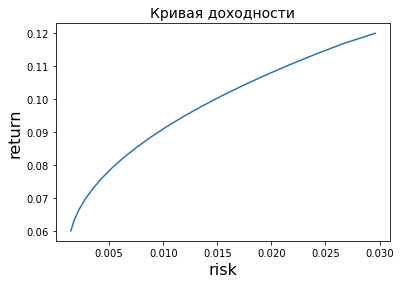

In [15]:
import matplotlib.pyplot as plt
n, rates = 5, np.linspace(0.06, 0.12, num=20) 
yields, risks = [], []
for r in rates:
    A = matrix(np.array([[1.0 for i in range(n)], yield_assets.Mean.tolist()]))
    b = matrix(np.array([[1.0], [r]]))
    q = matrix(0.0, (n,1))
    G = matrix(0.0, (n, n))
    G[::n+1] = -1.0
    h = matrix(0.0, (n,1))
    
    #covariation matrix * sigma
    cov_sigma = np.array([[covariation.iloc[i].tolist()[j] * yield_assets.Std_dev.tolist()[j] for j in range(n)] for i in range(n)])
    #P = sigma^T * covariation matrix * sigma
    P = matrix(np.array([[cov_sigma[j][i] * yield_assets.Std_dev.tolist()[j] for j in range(n)] for i in range(n)]))
    # Construct the QP, invoke solver
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    yields.append(r)
    risks.append(2.0 * solution['primal objective'])

fig, ax = plt.subplots()  
ax.set_title('Кривая доходности', fontsize=14)
plt.xlabel('risk', fontsize=16, rotation=0)
plt.ylabel('return', fontsize=16, rotation=90)
plt.plot(risks, yields)
plt.show()

Наложим ограничения на минимальные значения весов; каждый из весов должен быть не менее 5% от всего портфеля
$ \forall i \hspace{0.2cm} x_{i} \geq h_{i}:$
$$
G = 
\begin{bmatrix}
-1    &     &   \\
 &  \ddots  &   \\
 &    &     -1
\end{bmatrix}, \hspace{0.2cm} h = \left[ \begin{aligned} -0.05 \\ \vdots  \\ -0.05  \end{aligned} \right]
$$

In [96]:
for r in rates:
    A = matrix(np.array([[1.0 for i in range(n)], yield_assets.Mean.tolist()]))
    b = matrix(np.array([[1.0], [r]]))
    q = matrix(0.0, (n,1))
    G = matrix(0.0, (n, n))
    G[::n+1] = -1.0
    h = matrix(-0.05, (n,1))
    
    #covariation matrix * sigma
    cov_sigma = np.array([[covariation.iloc[i].tolist()[j] * yield_assets.Std_dev.tolist()[j] for j in range(n)] for i in range(n)])
    #P = sigma^T * covariation matrix * sigma
    P = matrix(np.array([[cov_sigma[j][i] * yield_assets.Std_dev.tolist()[j] for j in range(n)] for i in range(n)]))
    # Construct the QP, invoke solver
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    # Extract optimal value and solution
    print(' \n weights: ')
    print(solution['x'],'sum of weights = ', sum(solution['x']))
    print(' yield = ', sum([solution['x'][i] * yield_assets.Mean.tolist()[i] for i in range(n)]))
    print('total risk = ', solution['primal objective'])

 
 weights: 
[ 5.04e-02]
[ 6.18e-02]
[ 5.00e-02]
[ 7.88e-01]
[ 5.00e-02]
 sum of weights =  1.0
 yield =  0.060000000000000005
 
 weights: 
[ 2.29e-01]
[ 1.82e-01]
[ 5.00e-02]
[ 4.88e-01]
[ 5.00e-02]
 sum of weights =  1.0
 yield =  0.08000000000000002
 
 weights: 
[ 4.14e-01]
[ 2.97e-01]
[ 5.00e-02]
[ 1.88e-01]
[ 5.06e-02]
 sum of weights =  0.9999999999999999
 yield =  0.1
 
 weights: 
[ 2.40e-02]
[ 9.04e-01]
[ 2.40e-02]
[ 2.40e-02]
[ 2.40e-02]
 sum of weights =  0.9999951456083418
 yield =  0.12000013128769951


Для доходности $r = 0.12$ это условие является невыполнимым